<img src="../code/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Workshop 2: Tutorial on behavior states</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 24th, 2023</h3> 
<h4 align="center">Day 4 team</h4> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Notebook outline and objectives </h2>
    
<p>In W1 we manually clustered/identified behavioral states. Our goal in this workshop 2 will be to ask the question whether we can do this more automatically, and to describe some computational tools for doing this.
    
<l1>We would introduce unsupervised mixture model
What is a mixture model? How do we fit it?
<l1>Then we’d talk about additional constraints on model
E.g. what is the timescale of state transitions?
<l1>Introduction to state-space models
<l1>Hidden Markov Model
<l1>Applying HMM to VB example session
    
<p>This notebook will show you how to extract behavioral states from data using dynamax as a versitile software toolkit.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>Let's take a moment to import our minmal set of packages
    
<ul> Dynamax is a package created in collaboration between the Linderman lab and Google building around a JAX engine. JAX is a functional language which handles the backend for fast computation while presenting similarly to numpy. This means that you'll want to carry state along between calls. 
<p> ipywidgets allows us to display progress bars used in Dynamax (specially the tqdm package)    

</div>

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax
    
import warnings
warnings.filterwarnings("ignore")

installing dynamax
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pynwb 2.2.0 requires numpy<1.24,>=1.16, but you have numpy 1.25.2 which is incompatible.
hdmf 3.4.7 requires numpy<1.24,>=1.16, but you have numpy 1.25.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange
import optax
import seaborn as sns

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Motivation for a principled automated method for state determination </h2>
<p> In workshop 1, we saw how behavior states can be inferred from hypothesis driven processing and manual thresholding of behavioral data. In the process, we noted how there were choices along the way which felt arbitrary and in some cases the results could depend strongly on those choices. For example, how would our results have dependended upon the choice of threshold or the use of other measures of task performance?
    
<p> In this workshop, we will motivate the use of one principled away (this is certainly not the only one!) which will allow us to infer behavior states in a principled and automated fashion. To begin, let's start by motivating this approach by looking back at the Visual Behavior Data from workshop 1. In it, we will focus our attention on extending our view to higher dimensional measures of behavior.
</div>

In [4]:
from allensdk.brain_observatory.ecephys.behavior_ecephys_session import BehaviorEcephysSession

from utils import get_session, get_session_table, get_units_table, get_probes_table, get_channels_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Lets start by recalling all the behavioral data we looked at in the previous workshop. If you recall, they were all ver correlated with the behavioral state. Let us infact visualize those correlations. 

In [5]:
example_sessions = [1139846596, 1124507277, 1069461581, ]

session_id = example_sessions[0]
session = get_session(session_id)

trial_metadata = session.trials

running_time = session.running_speed.timestamps
running_speed = session.running_speed.speed

pupil_time = session.eye_tracking.timestamps
pupil_area = session.eye_tracking.pupil_area

licks = session.licks
lick_times = licks.timestamps.values
flashes = session.stimulus_presentations[session.stimulus_presentations.active].copy()

go_trials =  trial_metadata[trial_metadata.go].index

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Now let's synchronize up our different behavioral measures in a trial-wise manner (for easy visualization) and put them into a data frame which we can interogate easily.    

</div>

In [6]:
# mean behavioral variables in each trial

trial_start = trial_metadata.start_time[np.where(trial_metadata.go)[0]]
trial_stop = trial_metadata.stop_time[np.where(trial_metadata.go)[0]]

# running
mean_speed = [np.nanmean(running_speed[np.logical_and(s1 <= running_time, running_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# pupil 
mean_pupil_area = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_time, pupil_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# lick rate
lick_rate = trial_metadata[trial_metadata.go].apply(lambda row : len(row['lick_times'])/(row['stop_time'] - row['start_time']), axis = 1).values

# hits
hit_rate = trial_metadata.hit[trial_metadata.go].rolling(10).mean().values

# putting it together in a dataframe
behavior = {'Trials': go_trials, 
            'Lick_rate': lick_rate, 
            'Hit_rate':hit_rate,
            'Running_speed': mean_speed, 
            'Pupil_area': mean_pupil_area}

behavior_data = pd.DataFrame(behavior)
behavior_data.head()

,Trials,Lick_rate,Hit_rate,Running_speed,Pupil_area
0,13,2.618505,NaN,36.486412,4302.616233
1,15,2.051469,NaN,33.135666,4091.505168
2,17,2.199990,NaN,35.149516,4063.258657
3,18,1.929265,NaN,53.751427,4064.078763
4,22,2.243334,NaN,38.937263,4220.875109


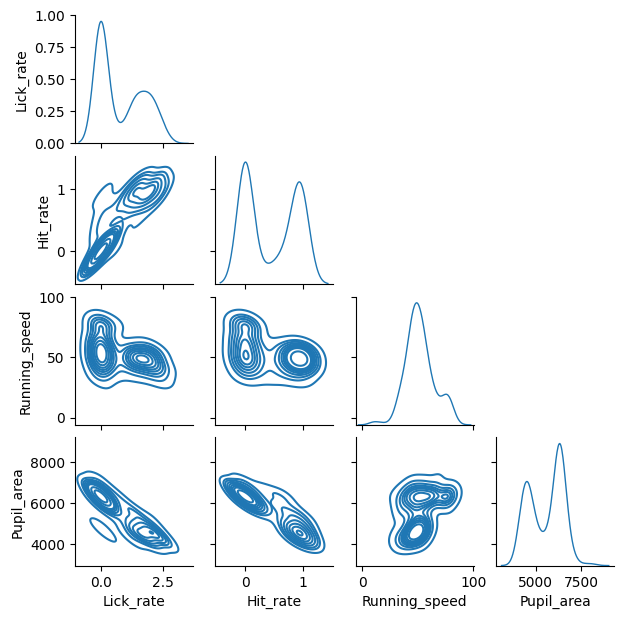

In [7]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = sns.PairGrid(behavior_data, hue = 'Trials', vars=['Lick_rate', 'Hit_rate','Running_speed', 'Pupil_area'], diag_sharey=False)
g.map_lower(sns.kdeplot, hue=None, lw = 0.5)
g.map_upper(hide_current_axis)
g.map_diag(sns.kdeplot, hue=None, lw=1, legend=False)
g.fig.set_size_inches(6,6)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.1: </b> In the last workshop, we saw that engaged mice tend to stop to lick. Try plotting up the variance of the running speed in place of the running speed itself. Discuss with your neighbors which choice gives you more insight into the trialwise mouse behavior.
</div>

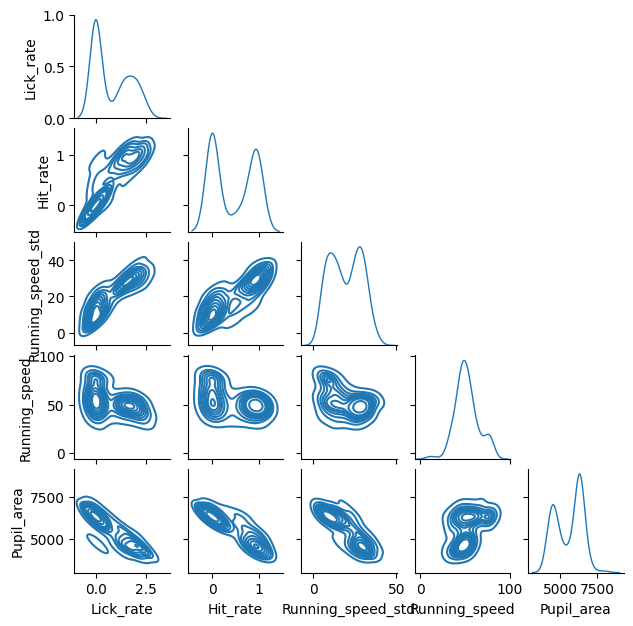

In [10]:
# Code block for task 2.1 with starter code.

std_speed = [np.nanstd(running_speed[np.logical_and(s1 <= running_time, running_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

# putting it together in a dataframe
behavior2 = {'Trials': go_trials, 
            'Lick_rate': lick_rate, 
            'Hit_rate':hit_rate,
            'Running_speed_std': std_speed,
            'Running_speed': mean_speed,
            'Pupil_area': mean_pupil_area}

behavior_data2 = pd.DataFrame(behavior2)

g = sns.PairGrid(behavior_data2, hue = 'Trials', vars=['Lick_rate', 'Hit_rate','Running_speed_std','Running_speed', 'Pupil_area'], diag_sharey=False)
g.map_lower(sns.kdeplot, hue=None, lw = 0.5)
g.map_upper(hide_current_axis)
g.map_diag(sns.kdeplot, hue=None, lw=1, legend=False)
g.fig.set_size_inches(6,6)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> How many behavior states are there? </h3>
<p> Even in this simple behavioral data with only 4 dimensions, we hope you'll notice how challenging this can be. 
    
<p> Does every peak deserve a behavior state?
    
<p>Where do you draw the planar seperation between engaged and disengaged? 
    
<p>Are there other behavior states that we should identify?
    
<p> These questions motivate us to ask: is there an automated way to make sense of this analysis?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Gaussian Mixture Models </h2>

<p> We hope that some of you are thinking back to Day 3: where we used unsupervised clustering such as K-means to identify cell types. Should we try the same thing here?
    
<p> This connection gives us the opportunity to introduce Gaussian mixture models and draw a link to k-means clustering. By making this connection, we will introduce a new tool to your toolbox: the notion of a mixture model which maximizes the liklihood of the observed data.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> K-means and Gaussian Mixture Models</h2>
    
<p> First, lets sort out our notations: 
<br> <b> Constants and data </b> 
<br> $N$ - number of data points. 
<br> $K$ - number of clusters/components
<br> $x_{n} \in R^{D}$ - $n^{th}$ input data point
<br> $z_{n} \in \{1, ..., K\}$ - cluster/component assignment for $n^{th}$ data point
<br> <b> Model parameters</b>   
<br> $\theta_{k}$ - parameters of the $k^{th}$ cluster/component
<br> $\pi$ - component probabilities/cluster proportions
<br> <b> Model hyperparameters</b>   
<br> $\phi$ - hyperparameters of the prior on $\theta$ 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> The objective of GMM is that, for each $n = 1, ..., N, $ we need to find $z_{n}^{*}$ and $\theta_{k}^{*}$ that maximizes the probability
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi)
\end{align}
<p> Lets assume a uniform distribution on the prior and $\pi = \frac{1}{K}\textbf{1}_{K}$,    
<br> To quantify $z_{n}^{*}$, we fix all variables but $z_{n}$, then, 
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi) \propto p(x_{n}|z_{n}, \{\theta\}_{k = 1}^{K}) = \mathcal{N}(x_{n}|\theta_{z_{n}}, \textbf{I})
\end{align}
<br> The <b>cluster/component assignment</b> that maximizes the likelihood is the one with the closest mean to $x_{n}$, that is, 
\begin{align}
z_{n}^{*} = \underset{k \in \{1,..., K\}}{arg min} || x_{n} - \theta_{k}||_{2}
\end{align}
<br> 2. Similarly, to quantify $\theta_{k}^{*}$, we fix all variables but $\theta_{k}$. In this case, 
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi) & \propto \prod_{n = 1}^{N} p(x_{n}|\theta_{k})^{\textbf{I}[z_{n} = k]} \\
    & \propto exp \biggl\{\sum_{n=1}^{N} \textbf{I}[z_{n} = k](x_{n}^{T}\theta_{k} - \frac{1}{2}\theta_{k}^{T}\theta_{k}) \biggr\}
\end{align}
<br> Taking the derivative of the log and setting to zero yields,
\begin{align}
\theta_{k}^{*} = \frac{1}{N_{n}}\sum_{n = 1}^{K} \textbf{I}[z_{n} = k]x_{n}, 
\end{align}   
<br> where, $N_{k} = \sum_{n=1}^{N}\textbf{I}[z_{n} = k]$
<p> If you recall from Day 3, this is the K-means algorithm!
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Expectation - Maximization </h2>
<p> K-Means made hard assignments of data points to clusters in each iteration. What if we used soft assignments instead? So, instead of assigning $z_{n}^{*}$ to the closest cluster, we compute <i>responsibilities</i> for each cluster. In that case, 
<br> 1. For each data point $n$ and component $k$, we set the <i>responsibility</i> to, 
\begin{align}
    \omega_{nk} = \frac{\pi_{k}\mathcal{N}(x_{n}|\theta_{k}, \textbf{I})}{\sum_{j = 1}^{K}\pi_{j}\mathcal{N}(x_{n}|\theta_{j}, \textbf{I})}
\end{align}
<br> 2. For each component $k$, we set the new mean to, 
\begin{align}
   \theta_{k}^{*} = \frac{1}{N_{k}}\sum_{n = 1}^{N}\omega_{nk}x_{n} 
\end{align}
<br> where $N_{k} = \sum_{n=1}^{N}\omega_{nk}$. 
    
<p> This is Expectation Maximization (EM). EM maximizes the marginal probability, instead of the joint probability and typically obtains faster convergence rates.  
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> But its not simply enough to fit a Gaussian distribution to our dynamics data. We want something which can also capture the notion of time. A choice which fulfills the goal is the "Gaussian Hidden Markov Model" or the "Gaussian HMM".
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Gaussian Hidden Markov Models (gHMM) </h2>
<p> Next, we will use Dynamax to introduce Gaussian HMMs on synthetic data.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Why Gaussian HMM? </h3>
<p> A Gaussian HMM introduces a simple notion of dynamics to the state determination that requires also fitting a transition matrix which tells you given you are in latent state i what is the rate of transitioning to latent state j.
    
A Gaussian HMM has emissions of the form,
\begin{align}
p(y_t \mid z_t, \theta) &= \mathcal{N}(y_t \mid \mu_{z_t}, \Sigma_{z_t})
\end{align}
where the emission parameters $\theta = \{(\mu_k, \Sigma_k)\}_{k=1}^K$ include the means and covariances for each of the $K$ discrete states.

Dynamax implements a variety of Gaussian HMMs with different constraints on the parameters (e.g. diagonal, spherical, and tied covariances). 
It also includes prior distributions on the parameters.
</div>

In [11]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap

from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.2: </b> As we discuss this these helper functions below, add to the docstring a comment about when you should use each of these helper functions. 
</div>

In [13]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title("Simulated data from an HMM")
    plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Generate in-silico data </h2>
<p> Next, we will use Dynamax to introduce Gaussian HMMs on synthetic data.
</div>

In [14]:
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
emission_dim = 2
hmm = GaussianHMM(true_num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, emission_dim - 2)),
    ])
emission_covs = jnp.tile(0.25**2 * jnp.eye(emission_dim), (true_num_states, 1, 1))
        
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))


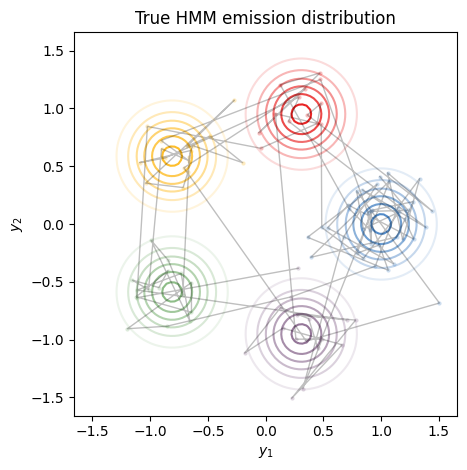

In [15]:
# Plot emissions and true_states in the emissions plane
plot_gaussian_hmm(hmm, true_params, train_emissions[0], train_true_states[0], 
                  title="True HMM emission distribution")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.3: </b> How does your gHMM data change as you alter the transmission matrix? How does it change when you alter the emission variance?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Visualize dynamics </h2>
<p> By plotting these states as a function of time, the interplay between descrete latent states, transition matrix mediated dynamics (Markov process) and the observations (or emissions) becomes more clear.
</div>

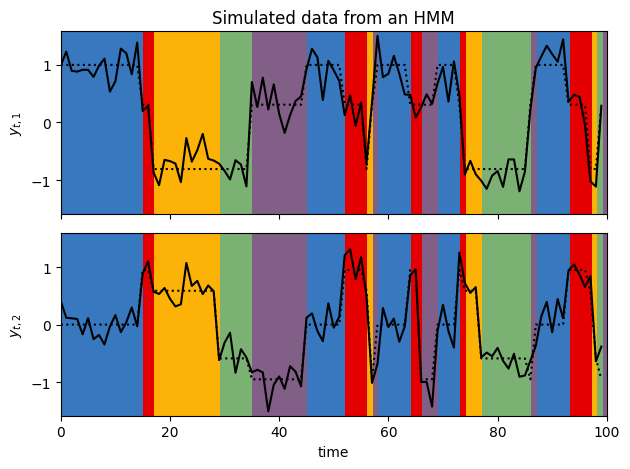

In [19]:
# Plot emissions vs. time with background colored by true state
plot_gaussian_hmm_data(hmm, true_params, train_emissions[0], train_true_states[0])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.4: </b> In this case we do know the underlying states because we made this HMM, but remember that as observers we only can see the emissions! Try plotting your emissions in a two 2 space. Are the clusters obvious?
</div>

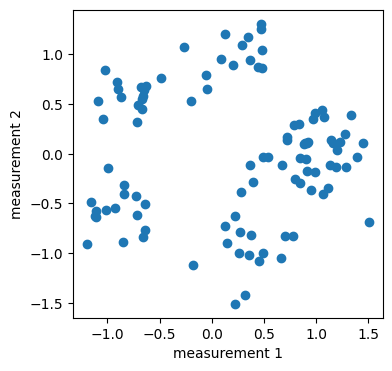

In [23]:
# code block to execute task 2.4

fig, ax = plt.subplots(1,1,figsize = [4,4])
ax.scatter(train_emissions[0][:,0], train_emissions[0][:,1])
ax.set_xlabel('measurement 1')
ax.set_ylabel('measurement 2')
plt.show()

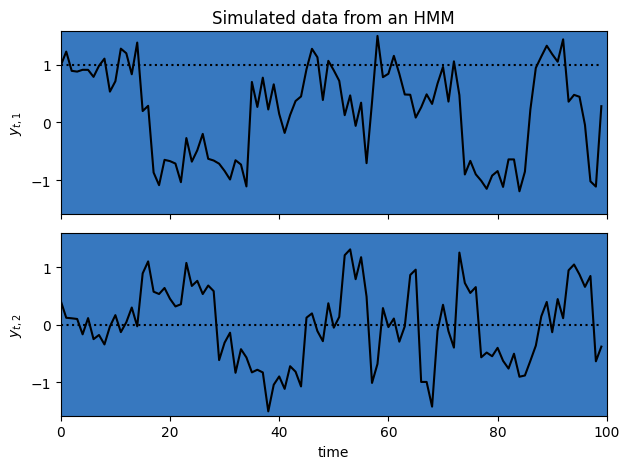

In [20]:
# Plot emissions vs. time with background colored by true state
plot_gaussian_hmm_data(hmm, true_params, train_emissions[0], np.zeros(train_true_states[0].shape, int))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Write a helper function to perform leave-one-out cross-validation </h3>
    
<p> In previous days, we've seen the vitial importance of cross-validation as a saneity check on your data to avoid overfitting. Let's bring those principles in here.
    
<p> This function fits the data into _folds_ where each fold consists of all
but one of the training sequences. It fits the model to each fold in 
parallel, and then computs the log likelihood of the held-out sequence for
each fold. The average held-out log likelihood is what we will use for 
determining the number of discrete states.
</div>



In [27]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method='kmeans', emissions=train_emissions)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls

In [28]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []
for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states
fitting model with 7 states
fitting model with 8 states
fitting model with 9 states


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.5:</b>  Plot up the average validation log-likelihood and discuss with your neighbor the implications of this curve shape? If you didn't know how many true states there where, how would you decide when to stop adding states? Will this lesson generalize to other types of data?
</div>

In [22]:
# Blank coding cell to work out Task 2.1


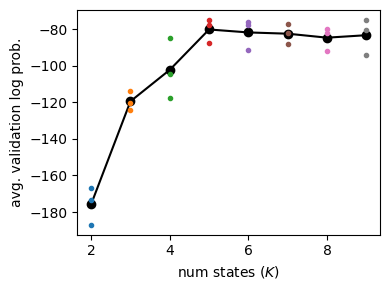

In [29]:
plt.figure(figsize = (4, 3))
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> How should we choose the right number of states? </h3>
    
<p> There's no single "right" answer for how to choose the number of states, but reasonable heuristics include:
    
<ul> * picking $K$ that has the highest average validation log prob
<p> * picking $K$ where the average validation log prob stops increasing by a minimum amount
<p> * picking $K$ with a hypothesis test for increasing mean
    
<p> Here, we'll just choose the number of states with the highest average.
</div>


In [30]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

best number of states: 5


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Now let's fit our model with the best number of states? </h3>
    
<p> Using the number of states with the highest average, we can fit our Gaussian HMM with dynamax.
</div>

In [31]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, emission_dim, transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=train_emissions)
params, lps = test_hmm.fit_em(params, props, train_emissions, num_iters=100)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.5:</b>  Plot up the log-likelihood and compare it to the actual lp.
</div>

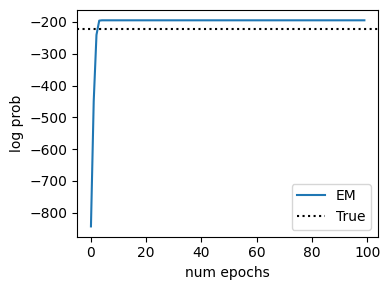

In [32]:
# Helper code for task 2.5

# Evaluate the log probability of the training data under the true parameters
true_lp = vmap(partial(hmm.marginal_log_prob, params))(train_emissions).sum()
true_lp += hmm.log_prior(params)

# Plot log probs vs num_iterations
offset = 0
plt.figure(figsize = (4, 3))
plt.plot(jnp.arange(len(lps)-offset), lps[offset:], label='EM')
plt.axhline(true_lp, color='k', linestyle=':', label="True")
plt.xlabel('num epochs')
plt.ylabel('log prob')
plt.legend()
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.6:</b>  Compare the inferred states to the actual states by using the plot_gaussian_hmm_data() method for both the inferred and actual states. Discuss with your neighbors what you observe and if you can spot any errors.
    
<p> If you finish early, please consider which of the features of this data would make it more difficult to reconstruct and what you might expect the failure to look like. What would happen if you choose too many states? Too few?
</div>

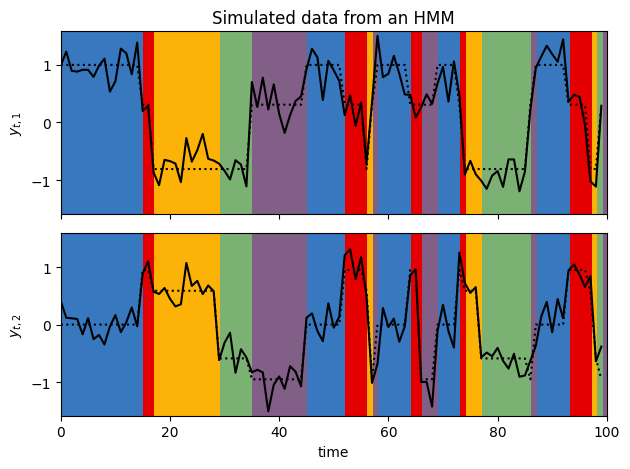

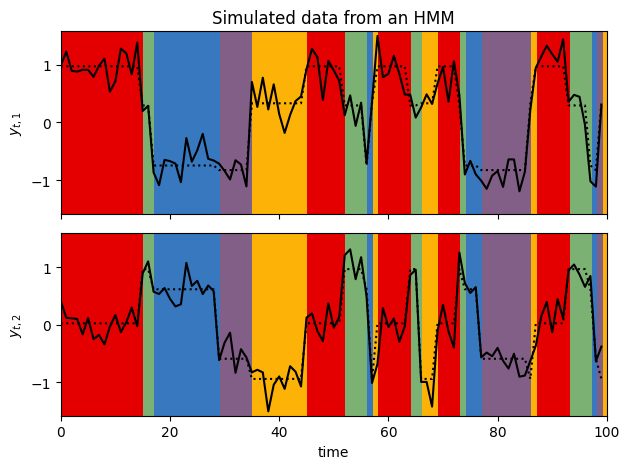

In [33]:
# helper code for task 2.6

plot_gaussian_hmm_data(hmm, true_params, train_emissions[0], train_true_states[0])

most_likely_states = hmm.most_likely_states(params, train_emissions[0])
plot_gaussian_hmm_data(hmm, params, train_emissions[0], most_likely_states)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> State determination in Visual Behavior mice </h2>
<p> Let's take what we've done above and merge it with our work in the previous workshop to extract automated detection of latent states in engaged/disengaged mice in the visual behavior dataset. 
<p> To accomplish this goal, let's use our Gaussian HMM toolkit to extract the behavior state evolution over the session in our 4 dimensional behavior space.
</div>

In [19]:
data = behavior_data[['Lick_rate','Running_speed', 'Pupil_area']].values
data[np.isnan(data)] = 0

# For this model, it's important that the data is converted into a *JAX* array
emissions = jnp.array(data)

# Split the data into equal length batches
n_batches = 3
n_steps = data.shape[0] - (data.shape[0] % n_batches)
batched_emissions = emissions[:n_steps, :].reshape(n_batches, -1, emissions.shape[1])
batch_size = batched_emissions.shape[1]

In [20]:
from sklearn.preprocessing import StandardScaler

avg_test_log_probs = []
std_test_log_probs = []
lp_all = []
numstates_all = []
key = jr.PRNGKey(0)
for num_states in range(2, 11):
    print("num states: ", num_states)
    
    test_log_probs = []
    for batch in trange(n_batches):
        # Extract all but this batch for training
        scaler = StandardScaler()
        train_emissions = scaler.fit_transform(np.concatenate([batched_emissions[:batch], batched_emissions[batch+1:]]).reshape((n_batches - 1)*batch_size, -1))
        
        # Make an HMM
        hmm = GaussianHMM(num_states, batched_emissions.shape[2])
        params, param_props = hmm.initialize(key=key, method="kmeans", emissions=jnp.array(train_emissions))

        # Fit the model
        params, lps = hmm.fit_em(params, param_props, jnp.array(train_emissions), num_iters=500)
        
        # Evaluate the log probability on held out data
        test_lp = hmm.marginal_log_prob(params, scaler.transform(jnp.array(batched_emissions[batch])))
        test_log_probs.append(test_lp)
        lp_all.append(test_lp)
        numstates_all.append(num_states)
       
    # Store the average test log prob
    avg_test_log_probs.append(np.mean(test_log_probs))
    std_test_log_probs.append(np.std(test_log_probs))    

num states:  2


  0%|          | 0/3 [00:00<?, ?it/s]

num states:  3


  0%|          | 0/3 [00:00<?, ?it/s]

num states:  4


  0%|          | 0/3 [00:00<?, ?it/s]

num states:  5


  0%|          | 0/3 [00:00<?, ?it/s]

num states:  6


  0%|          | 0/3 [00:00<?, ?it/s]

num states:  7


  0%|          | 0/3 [00:00<?, ?it/s]

num states:  8


  0%|          | 0/3 [00:00<?, ?it/s]

num states:  9


  0%|          | 0/3 [00:00<?, ?it/s]

num states:  10


  0%|          | 0/3 [00:00<?, ?it/s]

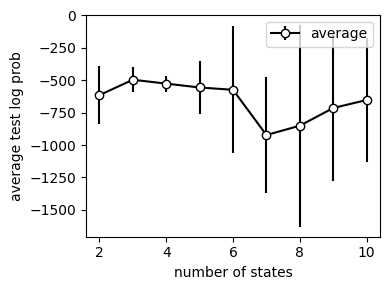

In [21]:
plt.figure(figsize = (4, 3))
plt.errorbar(np.arange(2, 11), avg_test_log_probs, yerr = std_test_log_probs, mfc = 'w', color = 'k', marker = 'o')
# plt.scatter(numstates_all, lp_all, c='k')
plt.legend(['average'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.7:</b>  Choose the best number of states and discuss with your neighbors why the shape of the cross-validation could be the way it is? Are there any other metrics you could use to decide on the number of states? 
</div>

In [23]:
# Blank coding cell to work out Task 2.7


In [211]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_test_log_probs))]
print("best number of states:", best_num_states)

best number of states: 3


In [212]:
key = jr.PRNGKey(0)
number_of_states = best_num_states
test_hmm = GaussianHMM(number_of_states, batched_emissions.shape[2], transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=batched_emissions[0])
params, lps = test_hmm.fit_em(params, props, np.nan_to_num(behavior_data[['Lick_rate','Running_speed', 'Pupil_area']].values), num_iters=500)

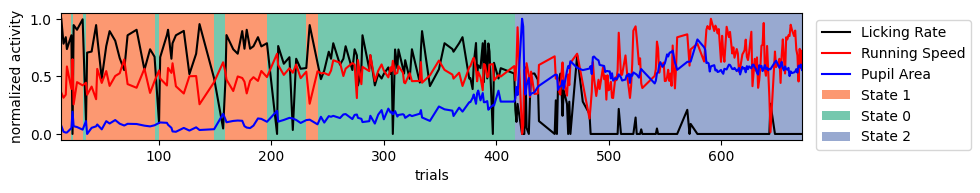

In [294]:
from matplotlib import colors

def minmax(x):
    return (x - np.min(x))/(np.max(x) - np.min(x)) 

# Find the most likely discrete states given the learned model parameters
most_likely_states = test_hmm.most_likely_states(params, behavior_data[['Lick_rate','Running_speed', 'Pupil_area']].values)

# Overlay the precision and recall curves on top of the inferred states
fig, ax = plt.subplots(figsize=(10, 2))
cmap =sns.color_palette("Set2", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

states = most_likely_states
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))
for i, trial in enumerate(switch_trials[:-1]):
    if states[trial+1] == 0: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor= cmap[0], alpha=0.9, label = 'State 0')
    elif states[trial+1] == 1:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor=cmap[1], alpha=0.9,label = 'State 1')
    elif states[trial+1] == 2:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor=cmap[2], alpha=0.9,label = 'State 2') 

plt.plot(go_trials, minmax(lick_rate), '-k', label="Licking Rate")
plt.plot(go_trials, minmax(mean_speed), '-r', label="Running Speed")
plt.plot(go_trials, minmax(mean_pupil_area), '-b', label="Pupil Area")
plt.xlim(go_trials[0], go_trials[-1])
plt.ylabel("normalized activity")
plt.xlabel("trials")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1))

plt.tight_layout()

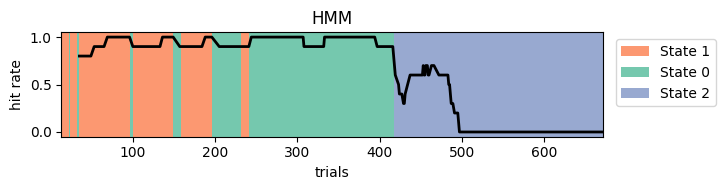

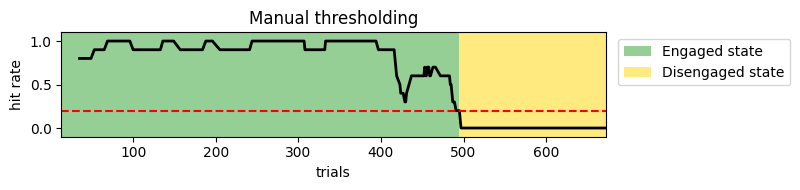

In [281]:
fig, ax = plt.subplots(figsize=(7.45, 2))
cmap = sns.color_palette("Set2", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

states = most_likely_states
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))
for i, trial in enumerate(switch_trials[:-1]):
    if states[trial+1] == 0: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor= cmap[0], alpha=0.9, label = 'State 0')
    elif states[trial+1] == 1:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor=cmap[1], alpha=0.9,label = 'State 1')
    elif states[trial+1] == 2:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor=cmap[2], alpha=0.9,label = 'State 2') 
plt.plot(go_trials, hit_rate, color = 'k', lw = 2)
plt.xlim(go_trials[0], go_trials[-1])
plt.xlabel("trials")
plt.ylabel('hit rate')
cb.set_label("discrete state")
plt.title('HMM')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1))
plt.tight_layout()

# From WS - 1 
engagement_threshold = 0.2
fig,ax = plt.subplots(figsize = (8.2, 2)) 
ax.plot(go_trials, hit_rate, color = 'k', lw = 2)
ax.plot(go_trials, 0.2*np.ones(len(go_trials)), color = 'r', ls = '--')

states = hit_rate < engagement_threshold
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(go_trials)-1]))
for i, trial in enumerate(switch_trials[:-1]):
    if not states[trial+1]: 
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='tab:green', alpha=0.5, label = 'Engaged state')
    else:
        ax.axvspan(go_trials[trial], go_trials[switch_trials[i+1]], facecolor='gold', alpha=0.5,label = 'Disengaged state')

ax.set_ylim(-0.1, 1.1)
ax.set_xlim(go_trials[0], go_trials[-1])
ax.set_xlabel('trials')
ax.set_ylabel('hit rate')
plt.title('Manual thresholding')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1))
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Homework problem:</b> Fit a GLM-HMM (in the form of a simplified Logistic Regression HMM) to the behavior data to identify states? Be sure to apply cross-validation and identify a reasonable number of states. Then study the latent states, the posterior distributions, and the state progression over trials. Does it agree with what you found in workshop1 and workshop2? 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Recalling our previous manual determination on this session. Do you see any signals of the disengaged state? How can we amplify them by defining the precision and recall?
    
   Rather than looking at all four of these quantities, we often summarize them in terms of the _precision_ (here, the fraction of licks that were hits) and _recall_ (here, the fraction of changes that the mouse hit)
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem/Project Idea:</b> You can think of the inferred behavioral states as features that have been derived from the behavioral data. These features are prime candidates to correlate with neural measurements. Do you think the neural responses to flashes/changes/omissions will differ from behavioral state to the next? 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem/Project Idea:</b> Likewise, we can correlate the inferred behavioral states with other aspects of the animal's behavior. Have we simply constructed a fancy way of extracting running speed and/or pupil size?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem/Project Idea:</b> How do the behavioral states differ across mice or sessions? Are some mice better performers than others?
</div>